In [1]:
import numpy as np
import plotly.graph_objects as go
import os
from sklearn.decomposition import PCA
import sys
import plotly.graph_objects as go
import time
from utils.utils import *
import matplotlib.pyplot as plt
import h5py
import scipy.io
np.random.seed(1234)

#Bilateral/2018-10-04_(S6)
file_path = "mc-1/data/Bilateral/2018-10-04_(S6)/ECoG.mat"
f = scipy.io.loadmat(file_path)
data = f.get("ECoG")
sampling_times = f.get("ECoG_time")
Fs = f.get("Fs")
print(data.shape)
print(data)
print(sampling_times.shape)
print(sampling_times)
print(Fs.shape)
print(Fs)

# Notes about data:
# sampled at 1kHz for ~12 mins -> 750k samples
# there are 64 electrodes


# Define frequency bands used in the paper (2020 "state based decoding of ECoG by Farrokhi and Erfanian")
frequency_bands = [
    (0.3, 5),    # δ
    (5, 15),     # θ–α
    (15, 30),    # β
    (30, 50),    # γ1
    (50, 100),   # γ2
    (100, 200),  # γ3
    (200, 400),  # hfECoG
]

(754998, 64)
[[  42.81 -252.29 -148.44 ...  -23.54  178.02  185.73]
 [ 157.19 -109.69  -69.58 ...   81.35  340.73  237.4 ]
 [ 168.54 -115.83   -8.33 ...   45.31  373.13  277.08]
 ...
 [ 236.56  193.65  153.85 ...   -2.4   317.6   292.81]
 [ 320.73  198.96  210.73 ... -163.44  159.69  200.94]
 [ 300.42  234.17  209.27 ...  -77.81  236.67  304.69]]
(754998, 1)
[[0.00000e+00]
 [1.00000e-03]
 [2.00000e-03]
 ...
 [7.54995e+02]
 [7.54996e+02]
 [7.54997e+02]]
(1, 1)
[[1000]]


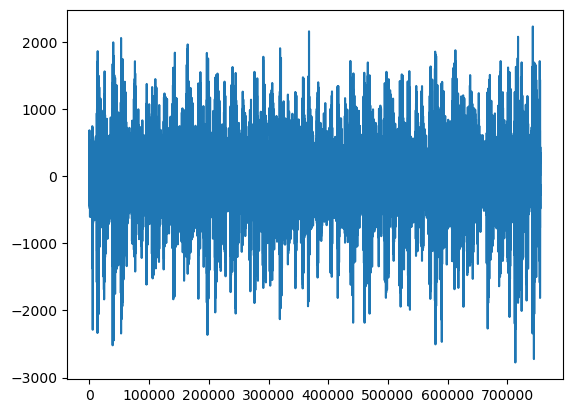

In [2]:
data[:,0].shape
plt.plot(data[:,0])

In [ ]:
# This is a large pre-processing step!
# The goal is to get a time-frequency representation of each electrode
# Instead of calculating the STFT, we calculate the frequency representation incurred by fitting an autoregressive model to a number of windows
# (We have 1s windows with a time step of 100ms --> about 1000 samples per window, and 100 samples per time step)
# basically each sample is modeled as a linear combination of the (20) previous inputs
# and we find the weights of this linear combination (for each window) by minimizing a least squares objective function 
# (modified covariance -- we include an error term for the forward fitting and one for the backward fitting. This admits a closed solution)
# then we transform each window's weights into a frequency domain representation of the window
# finally, we bin the frequency domain and average over each bin. The bins used are the same as from the paper!
# So, the output is (num_bins) x (num_windows) x (num_electrodes) ~~ 7 x 7,500 x 64

# the calculation is O(TC)
band_features = batch_ar_band_features(data)

In [ ]:
import pickle
with open("PROCESSED_DATA.pkl", "wb") as handle:
    pickle.dump(band_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
delta = band_features[0]
theta = band_features[1]
beta = band_features[2]
gamma_1 = band_features[3]
gamma_2 = band_features[4]
gamma_3 = band_features[5]
hfECoG = band_features[6]

vars, pca_result = scree_plot(gamma_3, 64, "gamma_3_scree_plot.png", "./figs/scree")
plot_3d(pca_result, "gamma_3", "./figs/3d")
print(dimensionality(vars)) # 13 dimensions (for linear subspace) capture 95% of variance!
make_plotly_fig(pca_result, "gamma_3_plotly", output_path="./figs/plotly")